## Importacion de librerias

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import random
from matplotlib import pyplot as plt #La libreria matplotlib la utilizamos para pintar gráficas
from matplotlib import patches as patches
import operator

## Definicion de funciones

In [2]:
"""
    Funcion 'generarPoblacion'
    
    Crea los individuos de la poblacion, o individuos nuevos para añadir a la poblacion existente
    
    Entradas: (
            - cantidad: Cantidad de individuos que tiene que generar {int}
        )
        
    Salidas:(
            - listaIndividuos: lista que contiene, en forma de listas, tantos individuos 
                               como se indique en el parametro de entrada a la funcion {list}
        )

"""

def generarPoblacion(cantidad):
    # Se crea la lista que contendra a los individuos
    listaIndividuos = []

    for individuo in range (0, cantidad):
        # Para cada individuo se crea una lista que contendra sus matrices de pesos
        listaIndividuos.append([])
        for i in range (0, MatrizPesos): 
            # Para cada individuo se crean los pesos de sus matrices aleatoriamente
            listaIndividuos[individuo].append(random.uniform(-1, 1))
            
    return listaIndividuos

In [3]:
"""
    Funcion 'obtenerPesosMLP'
    
    Dado un individuo, extrae sus datos y los separa para obtener las matrices de pesos que se crean
    entre la capa input y la hidden y entre las capas hidden y output
    
    Entradas: (
            - individuo: individuo de la poblacion. Consiste en una lista con los valores de ambas
                         matrices de pesos {list}
            - pesosEntrada: valor que corresponde a la cantidad de pesos que debe tener la matriz
                            que se crea entre la capa input y la hidden {int}
            - pesosIniciales: matrices de pesos creadas en el MLP del notebook auxiliar, las cuales
                              se utilizan simplemente para obtener sus dimensiones {list}
        )
        
    Salidas:(
            - listaPesos: lista que contiene, en forma de arrays de numpy, 4 matrices.
                          La primera corresponde a la matriz de pesos entre la capa input y la hidden,
                          la segunda es un array de ceros de la misma dimension que neuronas tiene la 
                          capa oculta (para guardar sus valores), la tercera es la matriz de pesos 
                          entre la capa hidden y la output y la cuarta es array de ceros de la misma 
                          dimension que neuronas tiene la capa de salida (para guardar sus valores) 
                          {list}
        )

"""

def obtenerPesosMLP(individuo, pesosEntrada, pesosIniciales):
    # Creacion de la matriz de pesos input-hidden
    matIH = individuo[0:pesosEntrada]
    # Creacion del array de los valores de las neuronas de la capa oculta
    valorH = np.zeros(len(pesosIniciales[0][0]))
    # Creacion de la matriz de pesos hidden-output
    matHO = individuo[pesosEntrada:len(individuo)]
    # Creacion del array de los valores de las neuronas de la capa de salida
    valorO = np.zeros(len(pesosIniciales[2][0]))
    
    listaPesos = [np.asarray(matIH).reshape(4, 20), valorH, np.asarray(matHO).reshape(20, 3), valorO]
    return listaPesos

In [4]:
"""
    Funcion 'funcionSigmoidea'
    
    Aplica la funcion sigmoidea al sumatorio pasado a una de las neuronas de la red
    
    Entradas: (
                - sumatorio: Sumatorio obtenido de la multiplicacion de los valores de las neuronas
                             de la capa anterior con los pesos de la matriz de pesos correspondiente 
                             {float}
            )
            
    Salidas: (
                - valor devuelto por la funcion sigmoidea {float}
            )

"""

def funcionSigmoidea(sumatorio):
    return 1/(1 + np.exp(-sumatorio))

In [5]:
"""
    Funcion 'funcionSoftmax'
    
    Aplica la funcion softmax al sumatorio pasado a una de las neuronas de la red
    
    Entradas: (
                - vectorSalidas: vector con las salidas que proporciona la red {list}
            )
            
    Salidas: (
                - vector con los valores devueltos por la funcion softmax {np.array}
            )

"""

def funcionSoftmax(vectorSalidas):
    return np.exp(vectorSalidas) / np.sum(np.exp(vectorSalidas))

In [6]:
"""
    Funcion 'obtenerSalidaRed'
    
    Dado un patron de entrada a la red, propaga la entrada por las capas de la red para obtener 
    la salida de la red para ese patron
    
    Entradas: (
                - pesos: lista que contiene, en forma de arrays de numpy, 4 matrices.
                         La primera corresponde a la matriz de pesos entre la capa input y la hidden,
                         la segunda es un array de ceros de la misma dimension que neuronas tiene la 
                         capa oculta (para guardar sus valores), la tercera es la matriz de pesos 
                         entre la capa hidden y la output y la cuarta es array de ceros de la misma 
                         dimension que neuronas tiene la capa de salida (para guardar sus valores) 
                         {list}
                - entrada: patron de entrada a la red {pandas.core.series}
            )
            
    Salidas: (
                - vector con las tres salidas proporcionadas por la capa de salida de la red
            )

"""

def obtenerSalidaRed(pesos, entrada):
    
    # Recorre la capa oculta, para asignar a cada neurona el valor que propagara a la siguente capa
    for hiddenNeuron in range(0, len(pesos[0][0])):
        # Variable que almacena el sumatorio de las entradas
        sumI = 0
        # Se realiza el sumatorio de las entradas de la capa anterior
        for valEntrada in range(0, len(entrada)):
            sumI += pesos[0][valEntrada][hiddenNeuron] * entrada[valEntrada]
        # Se aplica la funcion sigmoidea al valor del sumatorio (el valor que le llega a la neurona)
        # de la capa oculta
        sumI = funcionSigmoidea(sumI)
        # Se almacena el valor ya evaluado con la funcion sigmoidea en la neurona
        pesos[1][hiddenNeuron] = sumI
    
    # Se recorre la capa de salida, para asignar a cada neurona el valor que dara como salida
    for outputNeuron in range(0, len(pesos[2][0])):
        # Variable que almacena el sumatorio de las entradas
        sumI = 0
        # Se realiza el sumatorio de las entradas de la capa anterior
        for valOculta in range(0, len(pesos[1])):
            sumI += pesos[2][valOculta][outputNeuron] * pesos[1][valOculta]
            
        # Se almacena el valor obtenido en la neurona
        pesos[3][outputNeuron] = sumI
        
    return funcionSoftmax(pesos[3])

In [7]:
"""
    Funcion 'predecirEntrada'
    
    Dada la salida de la red, se obtiene la clase a la que la red cree que pertenece el patron y
    se compara con la clase real
    
    Entradas: (
                - vectorSalida: vector con los valores proporcionados por la capa de salida de la red
                
                - salidaEsperada: valor que determina la clase a la que pertenece el patron de entrada
                                  para saber si se ha predicho correctamente {int}
            )
            
    Salidas: (
                - 1: Si la clase predicha por la red coincide con la clase del patron
                - 0: Si la clase predicha por la red no coincide con la clase del patron
            )

"""

def predecirEntrada(vectorSalida, salidaEsperada):
    
    # Se busca la posicion del valor maximo en el vector de salidas de la red
    claseGanadora = np.where(vectorSalida == vectorSalida.max())[0][0]
    
    # Si esa posicion coincide con la clase, se cuenta un acierto
    if claseGanadora == salidaEsperada:
        return 1
    else:
        return 0

In [8]:
"""
    Funcion 'calcularFitness'
    
    Funcion que cuenta la cantidad de aciertos que obtiene un modelo con los 150 datos para calcular
    el fitness del individuo. En este caso, cuanto mas se acerque a 1 el fitness mejor sera, ya
    que significa que el modelo ha acertado en mas ocasiones
    
    Entradas: (
                - entradasRed: dataset con los patrones de entrada a la red {pd.DataFrame}
                
                - salidasRed: array de numpy con la clase a la que pertenece cada registro del dataset
                              {np.array}
                              
                - poblacion: lista que contiene todos los individuos de la poblacion {list}
                
                - cantidadPesosEntrada: valor que corresponde a la cantidad de pesos que debe tener 
                                        la matriz que se crea entre la capa input y la hidden {int}
                                        
                - pesosIniciales: matrices de pesos creadas en el MLP del notebook auxiliar, 
                                  las cuales se utilizan simplemente para obtener sus dimensiones 
                                  {list}
            )
            
    Salidas: (
                - listaFitness: lista con los valores de fitness correspondientes a cada individuo de
                                la poblacion {list}
            )

"""

def calcularFitness(entradasRed, salidasRed, poblacion, cantidadPesosEntrada, pesosIniciales):
    
    # Se crea la lista que almacenara el fitness de cada individuo
    listaFitness = []

    # Si esta condicion es verdad, significa que solamente se ha pasado un individuo para analizar
    # el fitness, y por lo tanto no es necesario el bucle (el programa peta sino)
    if type(poblacion[0]) == float or type(poblacion[0]) == int:
        # Se obtienen de manera organizada las matrices de pesos del individuo
        pesos = obtenerPesosMLP(poblacion, cantidadPesosEntrada, pesosIniciales)
        
        # Se evalua cada registro del dataaest y se comprueba si se ha acertado o fallado
        aciertos = 0
        for i in range(0, len(entradasRed)):
            resultados = obtenerSalidaRed(pesos, entradasRed.iloc[i, :])
            aciertos += predecirEntrada(resultados, salidasRed[i])

        # Se guarda en la lista el fitness de ese individuo
        listaFitness.append(aciertos/len(entradasRed))
    else:
        
        # El funcionamiento es el mismo que el descrito anteriormente, pero con cada individuo
        # que se recorre con el bucle for
        for individuo in poblacion:
            pesos = obtenerPesosMLP(individuo, cantidadPesosEntrada, pesosIniciales)

            aciertos = 0
            for i in range(0, len(entradasRed)):
                resultados = obtenerSalidaRed(pesos, entradasRed.iloc[i, :])
                aciertos += predecirEntrada(resultados, salidasRed[i])

            listaFitness.append(aciertos/len(entradasRed))

    return listaFitness

In [9]:
"""
    Funcion 'entrecruzamiento'
    
    Funcion que se encarga de realizar las operaciones de seleccion, replicacion, mutacion y calculo
    del fitness de un nuevo individuo para cada individuo de la poblacion
    
    Entradas: (
                - listaIndividuos: lista que contiene los individuos de la poblacion {list}
                
                - fitnessIndividuos: lista que contiene el fitness de cada individuo de la poblacion
                                     {list}
            )
            
    Salidas: (
                - listaIndividuos: lista con los individuos de la poblacion (se devuelve por si se
                                   ha modificado alguno de ellos) {list}
                                   
                - fitnessNuevo: lista con el fitness de cada individuo de la nueva poblacion {list}
            )

"""

def entrecruzamiento(listaIndividuos, fitnessIndividuos):
    # lista con los indices de los individuos
    individuosAzar = list(range(0, len(listaIndividuos)))
    # lista con el fitness de cada individuo de la poblacion nueva
    fitnessNuevo = np.zeros(len(listaIndividuos))

    # Se escogen en un orden aleatorio todos los individuos de la poblacion
    for i in range(0, len(listaIndividuos)):
        # Se escoge un elemento de esa lista
        rnd = np.random.randint(len(individuosAzar))
        # El indice de ese elemento en la lista de individuos sera el individuo elegido
        elegido = individuosAzar[rnd]
        # Se elimina la posibilidad de repetir el individuo
        del individuosAzar[rnd] 

        # Se calcula la probabilidad de que el individuo elegido se replique
        probRep = fitnessIndividuos[elegido]/np.max(fitnessIndividuos)
        # Creo un aleatorio entre 0 y 1 para ver si el individuo se replica (si este numero aleatorio)
        # es mayor que 'probRep', el individuo no se replicara
        condRep = np.random.rand()

        # Si el numero generado aleatoriamente es menor que 'probRep', y probRep es diferente de 0,
        # el individuo se replicara
        if probRep >= condRep and probRep != 0:
            # Se escoge el individuo a borrar
            individuoBorrado = np.random.randint(len(listaIndividuos)) 

            # Se recorren los pesos del individuo a borrar
            for peso in range(0, len(listaIndividuos[elegido])):
                # Si este entero aleatorio es menor que Pm el gen muta
                condMutacion = np.random.rand() 

                # Si el numero generado aleatoriamente es menor que 'Pm', y pM es diferente
                # de 0, el gen mutara
                if Pm >= condMutacion and Pm != 0:
                    # El peso del borrado se sustituye por un aleatorio entre -1 y 1
                    listaIndividuos[individuoBorrado][peso] = random.uniform(-1, 1)
                else: # Si no se cumple la condicion se copia el peso del padre al borrado
                    listaIndividuos[individuoBorrado][peso] = listaIndividuos[elegido][peso]

            # Se calcula el fitness del nuevo individuo
            fitnessNuevo[individuoBorrado] = calcularFitness(X, y, listaIndividuos[individuoBorrado], cantidadPesosEntrada, pesosIniciales)[0]

    # Si algun individuo no se ha borrado, su fitness no se habra pasado a la lista nueva, 
    # por lo que se copia
    for i in range(0, len(fitnessNuevo)):
        if fitnessNuevo[i] == 0:
            fitnessNuevo[i] = fitnessIndividuos[i]
            
    return listaIndividuos, fitnessNuevo

In [10]:
"""
    Funcion 'obtenerMejoresCromosomas'
    
    Funcion que se encarga de buscar los mejores cromosomas de la generacion dada
    
    Entradas: (
                - listaIndividuos: lista que contiene los individuos de la poblacion {list}
                
                - fitnessIndividuos: lista que contiene el fitness de cada individuo de la poblacion
                                     {list}
            )
            
    Salidas: (
                - posBestFitness: lista con la posicion de la lista de los mejores individuos de 
                                  la poblacion {list}
                                   
                - bestFitness: lista con el valor del fitness de los mejores individuos {list}
            )

"""

def obtenerMejoresCromosomas(listaIndividuos, fitnessIndividuos):
    
    # Listas con las posiciones de los mejores individuos y sus fitness
    posBestFitness = [0]
    bestFitness = [0]
    
    # se recorre la lista de fitness para encontrar los valores mas altos
    for i in range(0, len(fitnessIndividuos)):
        
        # Si el valor encontrado es igual al que ya esta almacenado como mejor, se añaden nuevos
        # datos de este individuo a las listas
        if fitnessIndividuos[i] == bestFitness[0]:
            bestFitness.append(fitnessIndividuos[i])
            posBestFitness.append(i)
        
        # Si el valor encontrado es mayor al que ya esta almacenado, se limpian las listas y se añaden
        # estos datos como mejor valor
        if fitnessIndividuos[i] > bestFitness[0]:
            bestFitness.clear()
            posBestFitness.clear()
            bestFitness.append(fitnessIndividuos[i])
            posBestFitness.append(i)
            
    return posBestFitness, bestFitness

In [11]:
"""
    Funcion 'resumenGeneracion'
    
    Funcion que muestra los datos de la poblacion en una generacion dada
    
    Entradas: (
                - numGen: generacion de la que se quieren mostrar los datos {int}
                
                - listaIndividuos: lista que contiene los individuos de la poblacion {list}
                
                - fitnessIndividuos: lista que contiene el fitness de cada individuo de la poblacion
                                     {list}
            )
            
    Salidas: (
                - El mejor valor de fitness obtenido {float}
                - La cantidad de cromosomas con ese valor de fitness {int}
                - El porcentaje de la poblacion que representan {float}
                - Los pesos del cromosoma consenso {list}
                - El fitness del cromosoma consenso {float}
            )

"""

def resumenGeneracion(numGen, listaIndividuos, fitnessIndividuos):
    
    posBestFitness, bestFitness = obtenerMejoresCromosomas(listaIndividuos, fitnessIndividuos)

    print(f"\t- RESUMEN DE GENERACION\n--------------------------------------\nGeneracion: {numGen}")
        
    print(f"\nEl numero de cromosomas que destacan es de: {len(bestFitness)}" + 
          f"\nEstos representan el {(len(bestFitness)/len(listaIndividuos))*100} % de la poblacion" + 
          f"\nFitness: {bestFitness[0]}")
        
    print("\nPesos del primer individuo de los mejores de la poblacion:\n")
    pesosIndividuo = obtenerPesosMLP(listaIndividuos[posBestFitness[0]], cantidadPesosEntrada, pesosIniciales)
    print(pesosIndividuo[0], end = "\n")
    print(pesosIndividuo[2])
    
    # Se crea una lista con los diccionarios que almacenaran las veces que aparece un peso
    listaDiccionarios = []
    
    # Se recorren todos los pesos de todos los cromosomas para encontrar el mayor numero de repetidos
    # en cada posicion
    for i in range(0, len(listaIndividuos[0])):
        # Se crea el diccionario que almacenara esos valores
        dict = {}
        for j in range(0, len(listaIndividuos)):
            # Si el peso no ha salido aun
            if listaIndividuos[j][i] not in dict:
                dict[listaIndividuos[j][i]] = 1
            else: # Si el peso ya esta registrado
                dict[listaIndividuos[j][i]] += 1
        listaDiccionarios.append(dict)
    
    # Creacion del cromosoma consenso
    cromosomaConsenso = []
    # Se recorren todos los diccionarios, se ordenan y se obtiene la clave con el mayor valor, que 
    # corresponde al peso mas repetido de esa posicion
    for i in range(0, len(listaDiccionarios)): 
        dOrdenado = sorted(listaDiccionarios[i].items(), key = operator.itemgetter(1))
        cromosomaConsenso.append(dOrdenado[-1][0])

    # Se calcula el fitness del cromosoma
    fitnessConsenso = calcularFitness(X, y, cromosomaConsenso, cantidadPesosEntrada, pesosIniciales)[0]
    
    print(f"\nFitness del cromosoma consenso: {fitnessConsenso}\nPesos del cromosoma consenso: \n")
    pesosConsenso = obtenerPesosMLP(cromosomaConsenso, cantidadPesosEntrada, pesosIniciales)
    print(pesosConsenso[0], end = "\n")
    print(pesosConsenso[2])
    
    return bestFitness[0], len(bestFitness), (len(bestFitness)/len(listaIndividuos)), cromosomaConsenso, fitnessConsenso

In [12]:
"""
    Funcion 'resumenMuestra'
    
    Funcion que muestra los datos de la poblacion en una generacion dada y muestra el 20% de la
    poblacion escogido al azar
    
    Entradas: (
                - numGen: generacion de la que se quieren mostrar los datos {int}
                
                - listaIndividuos: lista que contiene los individuos de la poblacion {list}
                
                - fitnessIndividuos: lista que contiene el fitness de cada individuo de la poblacion
                                     {list}
            )
            
    Salidas: (
                - ninguna, solamente imprime informacion en pantalla
            )

"""

def resumenMuestra(numGen, listaIndividuos, fitnessIndividuos):
    
    print(f"\t- RESUMEN DE MUESTRA\n--------------------------------------\n")
    resumenGeneracion(numGen, listaIndividuos, fitnessIndividuos)
    porcentajeAMostrar = (len(listaIndividuos)*20)/100
    listaMostrar = []
    
    print("\nMuestreo del 20% de los individuos de la poblacion:\n\n")
    while(len(listaMostrar) != round(porcentajeAMostrar)):
        nuevoInd = np.random.randint(len(listaIndividuos))
        if nuevoInd not in listaMostrar:
            listaMostrar.append(nuevoInd)
            
    listaMostrar = np.sort(np.asarray(listaMostrar))
    
    for ind in listaMostrar:
        print(f"Individuo {ind}:\n")
        
        pesosIndividuo = obtenerPesosMLP(listaIndividuos[ind], cantidadPesosEntrada, pesosIniciales)
        print(pesosIndividuo[0], end = "\n")
        print(pesosIndividuo[2])
        print("---------------------------------------------------------------------------")

In [13]:
"""
    Funcion 'pintarGrafica'
    
    Funcion que muestra una grafica con los datos recogidos durante la realizacion del algoritmo
    
    Entradas: (
                - valoresX: valores de los datos a representar en el eje X {list}
                
                - valoresY: valores de los datos a representar en el eje Y {list}
                
                - valoresY1: valores de los datos a representar en el eje Y1 {list}
                                    
                - valoresY2: valores de los datos a representar en el eje Y2 {list}
                
                - matrizPeso: cantidad de pesos que tienen las matrices de cada individuo {int}
                
                - Npoblacion: cantidad de individuos que componen la poblacion {int}
                
                - Ngeneracion: generacion de la que se estan representando los datos {int}
                
                - xlabel: Texto que indica el valor que se representa en el eje X {string}
                
                - minX: valor minimo que se debe representar en el eje X {float}
                
                - maxX: valor maximo que se debe representar en el eje X {float}
            )
            
    Salidas: (
                - ninguna, solamente pinta una grafica en pantalla
            )

"""

def pintarGrafica(valoresX, valoresY, valoresY1, valoresY2, matrizPeso, Npoblacion, Ngeneracion, 
                  xlabel, minX, maxX):

    fig, ax = plt.subplots(figsize = (18,10))
    fig.subplots_adjust(right = 0.75)
    ax.set_title(f"Gráfica con matriz de pesos: {matrizPeso},  poblacion igual a: {Npoblacion} " +
                 f" y numero de generaciones: {Ngeneracion}")
    twin1 = ax.twinx()
    twin2 = ax.twinx()

    twin2.spines.right.set_position(("axes", 1.1))

    p1, = ax.plot(valoresX,valoresY, "y-", label = "Valores fitness", marker = '+')
    p2, = twin1.plot(valoresX,valoresY1 , "g-", label = "Cantidad mejores", marker = '*')
    p3, = twin2.plot(valoresX,valoresY2 , "r-", label = "Porcentaje representado", marker = 'o')

    ax.set_xlabel(xlabel)
    if xlabel == 'Generacion':
        ax.set_xlim(minX-2, maxX+2, 10)
    else:
        ax.set_xlim(minX, maxX, 10)
    ax.set_ylabel("Valores fitness")
    ax.set_ylim(0, 1)
    twin1.set_ylabel("Cantidad mejores")
    twin1.set_ylim(0, Npoblacion+3)
    twin2.set_ylabel("Porcentaje representado")
    twin2.set_ylim(0, 1)


    ax.yaxis.label.set_color(p1.get_color())
    twin1.yaxis.label.set_color(p2.get_color())
    twin2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size = 4, width = 1.5)
    ax.tick_params(axis = 'y', colors = p1.get_color(), **tkw)
    twin1.tick_params(axis = 'y', colors = p2.get_color(), **tkw)
    twin2.tick_params(axis = 'y', colors = p3.get_color(), **tkw)
    ax.tick_params(axis = 'x', **tkw)

    ax.legend(handles=[p1,p2,p3])

## Creacion del MLP con keras

#### Aunque esta parte se pide implementar en un notebook aparte, he decidido ponerla aqui tambien para que al ejecutar el notebook se genere el archivo que se utiliza para obtener las dimensiones de las matrices de pesos y sus pesos

In [14]:
inputs = keras.Input(shape=(4,), name = 'Input')
x = layers.Dense(20, activation = 'sigmoid', name = 'dense_1')(inputs)
outputs = layers.Dense(3, activation = 'softmax', name = 'Output')(x)

model = keras.Model(inputs = inputs, outputs = outputs, name = '3_layer_mlp')
model.summary()

model.save('PesosInicializadosMLP.h5')

Model: "3_layer_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 20)                100       
                                                                 
 Output (Dense)              (None, 3)                 63        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


## Importacion de pesos creados en el MLP auxiliar

In [15]:
model = keras.models.load_model('PesosInicializadosMLP.h5', compile = False)
pesosIniciales = model.get_weights()

## Preprocesamiento de datos

In [16]:
datosRaw = pd.read_csv('Dataset/iris.data', header = None)
datosRaw.columns = ['Sepal-length','Sepal-width','Petal-length','Petal-width', 'Iris-type']
datosRaw

,Sepal-length,Sepal-width,Petal-length,Petal-width,Iris-type
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [17]:
X = datosRaw.drop('Iris-type', axis = 1)
y = datosRaw['Iris-type']

In [18]:
labelEncoder = LabelEncoder()
scaler = MinMaxScaler()

# Se normalizan los datos de los atributos de entrada
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
# Se codifican los datos de las salidas
# 0 = Iris-setosa, 1 = Iris-versicolor , 2 = Iris-virginica
y = labelEncoder.fit_transform(y)

## Algoritmo genetico

In [39]:
cantidadPesosEntrada = len(pesosIniciales[0])*len(pesosIniciales[0][0])
cantidadPesosSalida = len(pesosIniciales[2])*len(pesosIniciales[2][0])

MatrizPesos = cantidadPesosEntrada + cantidadPesosSalida # Numero de pesos de la matriz de pesos
NPOB = 25 # Numero de individuos de la poblacion
NGEN = 1000 # Numero de generaciones (ciclo completo sobre todos los individuos)
Pm = 0.05 # Probabilidad de mutacion: probabilidad de que un gen dado mute
NRES = 50 # Cada cuantas generaciones se imprime un resumen de la evolucion del proceso
NSAMPLE = 200 # Cada que numero de generaciones se saca un muestreo de la poblacion

#### Algoritmo genetico en el que la probabilidad de mutacion no cambia durante la ejecucion

In [20]:
# Se genera la poblacion inicial de individuos
listaIndividuos = generarPoblacion(NPOB)

# Se calcula el fitness de todos ellos
fitnessIndividuos = calcularFitness(X, y, listaIndividuos, cantidadPesosEntrada, pesosIniciales)

In [21]:
print(f"------------------\nMatrizPesos: {MatrizPesos}\nNumero de individuos de la poblacion: {NPOB}" +
      f"\nNumero de generaciones: {NGEN}\nProbabilidad de mutacion: {Pm}\n------------------\n\n")

contNRES = 1
contNSAMPLE = 1

# Listas para almacenar los valores necesarios para pintar graficas
# Estos valores solamente se almacenaran cada vez que se cumpla la condicion 'contNRES%NRES == 0'
valoresFitness1 = []
valoresNumMejores1 = []
valoresPorcentajeRepresentado1 = []
valoresGeneracion1 = []
cromosomasConsenso1 = []
fitnessConsenso1 = []

generaciones = NGEN

while generaciones != 0:    
    
    listaIndividuos, fitnessIndividuos = entrecruzamiento(listaIndividuos, fitnessIndividuos)
    
    
    if contNRES%NRES == 0:
        bestF, cantidadMejores, porcentaje, cConsenso, fConsenso = resumenGeneracion(contNRES, listaIndividuos, fitnessIndividuos)
        
        valoresFitness1.append(bestF)
        valoresNumMejores1.append(cantidadMejores)
        valoresPorcentajeRepresentado1.append(porcentaje)
        valoresGeneracion1.append(contNRES)
        cromosomasConsenso1.append(cConsenso)
        fitnessConsenso1.append(fConsenso)
        
        print("\n\n")

    if contNSAMPLE%NSAMPLE == 0:
        resumenMuestra(contNRES, listaIndividuos, fitnessIndividuos)
        print("\n\n")
        
        
    contNRES += 1
    contNSAMPLE += 1
    generaciones -= 1
    
print("\n\n<<<< EL ALGORITMO HA FINALIZADO SU EJECUCION >>>>\n")
resumenMuestra(contNRES-1, listaIndividuos, fitnessIndividuos)

------------------
MatrizPesos: 140
Numero de individuos de la poblacion: 25
Numero de generaciones: 1000
Probabilidad de mutacion: 0.05
------------------


	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 50

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.64

Pesos del primer individuo de los mejores de la poblacion:

[[-0.60228516 -0.47975785  0.6397744   0.59899931  0.48714531 -0.52557931
  -0.38854808 -0.38330008 -0.89518581  0.37515432 -0.89736202 -0.08545666
  -0.48661133  0.05352475  0.4760511   0.785532    0.04165393 -0.65553147
  -0.27941533 -0.86243957]
 [-0.69607868 -0.55270087  0.29911296  0.13757597 -0.2040845  -0.58791289
  -0.71870811 -0.16320593 -0.91816915  0.2211438  -0.77220555 -0.77697861
   0.93492917  0.53092225  0.24973441  0.09974754 -0.56624262  0.22208284
  -0.70860577  0.57761431]
 [ 0.77325312 -0.85798357  0.15987834 -0.467505   -0.16124829  0.15149894
   0.75943482 -0.46419027 

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 200

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.6666666666666666

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.23445603  0.12383869 -0.54530953 -0.38419826 -0.54991639  0.94745162
   0.11704031 -0.42960972  0.81907676 -0.19512447 -0.94158098 -0.7381894
  -0.79802644  0.47032643  0.66846828 -0.13283448  0.84715324 -0.89449685
  -0.92699271 -0.74634847]
 [ 0.27558767  0.66729389 -0.90263931  0.94996479  0.13332948  0.51751799
  -0.50101178 -0.59289157 -0.31871673 -0.70325511  0.12752398  0.60484433
  -0.16118187  0.80722627  0.6664043  -0.84208655 -0.62986493  0.41977307
   0.72670363 -0.19611927]
 [ 0.23846621  0.21601608 -0.78693093 -0.90812358 -0.45353796  0.13454995
   0.26525204 -0.73132524 -0.76772985  0.618344   -0.21936697  0.53639834
  -0.163024   -0.55337795  0.97246688  0.90505529  0.24083919  0.61254409
   0.9843344  -0.82003

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 250

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.41333333333333333

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.54520293  0.50767517  0.81290953  0.40324849 -0.1916047  -0.28340216
  -0.46406555  0.62820898 -0.11355776  0.57084388 -0.44329307  0.65946909
  -0.65303806  0.47032643  0.53233832 -0.9348432   0.52222614  0.01557991
  -0.66004279  0.91333634]
 [-0.60660875 -0.42354013 -0.37019544 -0.92407253 -0.22052629 -0.02740875
   0.43018092 -0.23889692 -0.93964309 -0.48203602  0.05519243  0.47154488
  -0.92040689 -0.69936263 -0.49481568 -0.04661658  0.76613511 -0.38587067
   0.6119281   0.4377993 ]
 [ 0.49701876 -0.74230521  0.90439901  0.21994443  0.32804689 -0.70925565
  -0.49065225 -0.00505639  0.7996968  -0.40533674 -0.55407018 -0.54471327
   0.28127595 -0.1816145   0.2357752   0.80660641  0.65745693  0.63699436
  -0.6417189   0.822

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 400

El numero de cromosomas que destacan es de: 3
Estos representan el 12.0 % de la poblacion
Fitness: 0.6666666666666666

Pesos del primer individuo de los mejores de la poblacion:

[[-0.52081594  0.94425134  0.27817096  0.97682709  0.19493178  0.81799143
  -0.88103217  0.91662589 -0.47824359 -0.66105609 -0.01782011  0.6577844
   0.63679065 -0.67591486 -0.78788336  0.88256455 -0.36081003 -0.92135649
  -0.75786254  0.09936727]
 [ 0.15705708 -0.63446908 -0.58877667  0.82204636 -0.56610202  0.42174478
   0.27859107  0.99132109 -0.50743295  0.43067724  0.8527679  -0.56839869
   0.89737114 -0.69219727  0.85177648  0.88175731 -0.01320449 -0.01790324
  -0.74401765  0.13495517]
 [-0.28667269  0.83543277 -0.81606658 -0.11281951  0.22691242  0.81778518
  -0.81620192  0.61670609  0.18415806 -0.62913593  0.94421979  0.68867397
   0.19215647  0.24689081  0.18104692 -0.5266853  -0.99537259 -0.23095777
   0.10587902  0.2660

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 450

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.6666666666666666

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.98037263  0.3768108   0.27817096  0.64127852  0.19493178  0.75156169
   0.08632585 -0.73797659 -0.47824359  0.52598328  0.35063286  0.91719733
  -0.31498731 -0.6717859   0.71366625 -0.21017396  0.48688854  0.4537293
   0.4518758  -0.90817792]
 [ 0.55050709  0.61293695  0.2257745   0.82204636 -0.56610202  0.81238856
   0.27859107  0.99132109  0.04920817 -0.4559528   0.8527679  -0.56839869
   0.89737114  0.85583381 -0.31650684  0.88175731 -0.38699959 -0.85640215
   0.28966406  0.48606248]
 [-0.9313782  -0.90191147  0.90821201  0.67772374  0.11460145  0.80970262
  -0.81620192  0.71257834 -0.47243402 -0.615114    0.94421979  0.68867397
  -0.09726941 -0.66792495 -0.43826204  0.57462511  0.40832198  0.72146109
   0.10587902 -0.96816

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 600

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.64

Pesos del primer individuo de los mejores de la poblacion:

[[-0.12185818 -0.71222686 -0.39827787  0.59364632  0.11797788 -0.24459873
  -0.84897619  0.31186216 -0.87530017  0.48888587  0.6949458   0.08115477
  -0.49779864  0.34523121  0.56103592  0.56793542 -0.20212572 -0.32634181
  -0.14658989 -0.25489216]
 [-0.54366443 -0.2275764  -0.44678011 -0.5713884  -0.70295577  0.95701694
  -0.51865764 -0.16361605 -0.26966398 -0.0161196   0.8527679   0.87770891
  -0.13265506  0.1777906  -0.12090867  0.6355993   0.74455957  0.91249648
  -0.97659994 -0.52877332]
 [-0.85560571 -0.3360822   0.99769106 -0.96891097 -0.52811228 -0.69269807
  -0.17169969 -0.61340613  0.93922716 -0.88165012 -0.29624882 -0.85206536
   0.4152763  -0.74981286  0.37165428  0.04977896  0.38884004 -0.02601923
   0.69558746 -0.10291935]
 [ 0.529

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 650

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.6666666666666666

Pesos del primer individuo de los mejores de la poblacion:

[[-0.9890899   0.08251064 -0.39827787 -0.01577727  0.85378794 -0.07405832
   0.12410205 -0.5247449  -0.20610798  0.1654287  -0.03054196  0.54493735
  -0.00839119  0.71896435 -0.15111966  0.90239551 -0.20212572 -0.54888976
  -0.40539029  0.59121626]
 [-0.58908159  0.85130169 -0.54047856 -0.81165899 -0.46311324  0.87090988
   0.50766043 -0.18300597 -0.35357546  0.49029577  0.8527679   0.56368632
   0.92517491 -0.0793682  -0.12090867 -0.04127482 -0.05809403 -0.43574266
   0.37854709 -0.00256648]
 [-0.77522653  0.67691541  0.14433103 -0.44271973 -0.52811228  0.76499133
   0.18993809 -0.69399831  0.93922716 -0.88165012 -0.29624882 -0.8342154
   0.4152763   0.95708867  0.35347972  0.26895511  0.68636695  0.72146109
  -0.4820332   0.96946

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 800

El numero de cromosomas que destacan es de: 2
Estos representan el 8.0 % de la poblacion
Fitness: 0.6666666666666666

Pesos del primer individuo de los mejores de la poblacion:

[[-0.33738064  0.4123645   0.77151627  0.41431702  0.46583372  0.0753996
  -0.33246197 -0.16069613 -0.56473572  0.80486509  0.05406993 -0.24262546
  -0.85274268 -0.14251452  0.14446256  0.93574157  0.44763409 -0.5766894
   0.44716367  0.20553656]
 [ 0.65989133  0.05792396 -0.34351092  0.86692751 -0.03263489  0.72493217
   0.49820724  0.46435843  0.58985827 -0.33166617  0.62416756  0.96272775
   0.336819    0.84877631 -0.67955639  0.01122144  0.21342082  0.79085793
   0.4457882  -0.95607664]
 [ 0.63032924  0.1260894  -0.63588858 -0.93437546  0.10739985  0.00477506
   0.18993809  0.67743009 -0.78943502 -0.94946207  0.11804038 -0.99857501
  -0.22729868  0.44857097  0.15129594  0.63071077 -0.55299706 -0.01753481
  -0.52254487 -0.691807

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 850

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.6333333333333333

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.11830134  0.4123645   0.77151627 -0.6049637   0.10596775  0.02459202
  -0.77860046 -0.16069613 -0.56473572 -0.76793396 -0.28888849 -0.1450797
  -0.49169446 -0.88563621  0.14446256  0.87694582 -0.25266485  0.43406273
  -0.65135198 -0.09816783]
 [ 0.65989133 -0.64648019 -0.34351092  0.80077122 -0.03263489 -0.86400552
   0.00495932 -0.11399381  0.73309834  0.31766298 -0.39160582  0.92850915
   0.89025454  0.13167664 -0.80339891 -0.94691956 -0.08345298 -0.33026361
  -0.49016422 -0.95607664]
 [ 0.63032924  0.1260894  -0.05021298 -0.51990312  0.31660837  0.00477506
   0.70329474  0.49613833 -0.86639983 -0.87397359  0.49973211 -0.74750919
   0.11979976 -0.02582815  0.43668374  0.96397939  0.13518728 -0.65698996
  -0.49868379 -0.47988

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 1000

El numero de cromosomas que destacan es de: 23
Estos representan el 92.0 % de la poblacion
Fitness: 0.3333333333333333

Pesos del primer individuo de los mejores de la poblacion:

[[-8.26106986e-02  1.32382987e-01 -4.37233192e-01 -4.54670272e-01
  -9.23324406e-01  9.83020842e-01 -4.52462606e-01  6.44394958e-01
   2.33147231e-01 -5.51899653e-02  8.87158817e-01  1.77242389e-01
  -7.79131694e-01 -6.68791761e-01  8.26165287e-01 -8.77121450e-01
  -3.16161054e-01  8.06339622e-01 -7.05675290e-01  3.77242320e-01]
 [-8.32210691e-03  9.13658415e-01  2.22684506e-01  1.27304761e-01
  -5.55887485e-01  2.12513901e-01 -1.32533656e-01  9.69409385e-02
  -4.04233233e-01 -7.28921798e-01  5.51843322e-01  8.45860840e-01
   3.36825985e-01  4.36680846e-01 -6.70534096e-01 -2.95763779e-01
  -3.17749808e-01 -6.32835403e-01 -1.57012060e-04  7.64820706e-01]
 [ 2.59551308e-01  3.74406545e-01 -3.99411211e-01  5.71793145e-01
  -4.88488


Fitness del cromosoma consenso: 0.0
Pesos del cromosoma consenso: 

[[-7.96613778e-02  7.13462183e-01  7.89260526e-01 -4.54670272e-01
  -9.23324406e-01  7.32075175e-02 -4.52462606e-01  6.44394958e-01
   2.33147231e-01 -5.51899653e-02  8.87158817e-01  1.77242389e-01
  -8.65348213e-02 -6.68791761e-01  8.26165287e-01 -8.77121450e-01
  -2.41447814e-01  8.06339622e-01 -7.05675290e-01 -6.84979220e-02]
 [-8.32210691e-03  9.13658415e-01  2.22684506e-01 -3.36909247e-02
  -5.55887485e-01  2.12513901e-01 -5.77775074e-01  9.69409385e-02
  -1.50885403e-01 -7.28921798e-01 -1.66184741e-01 -5.28910815e-01
   7.58012708e-01  3.96613711e-01 -6.70534096e-01 -2.95763779e-01
   6.82656971e-01  2.63951171e-01 -1.57012060e-04  7.64820706e-01]
 [ 2.59551308e-01  4.00449778e-01 -3.99411211e-01  5.71793145e-01
  -4.88488078e-01 -4.70547670e-01 -4.20196204e-01  3.77394043e-01
  -9.64522302e-01 -7.26727781e-01  5.00904889e-01 -7.51485944e-01
  -9.93918462e-02  8.84173378e-01 -8.47405848e-01 -3.53354833e-01
  -5.

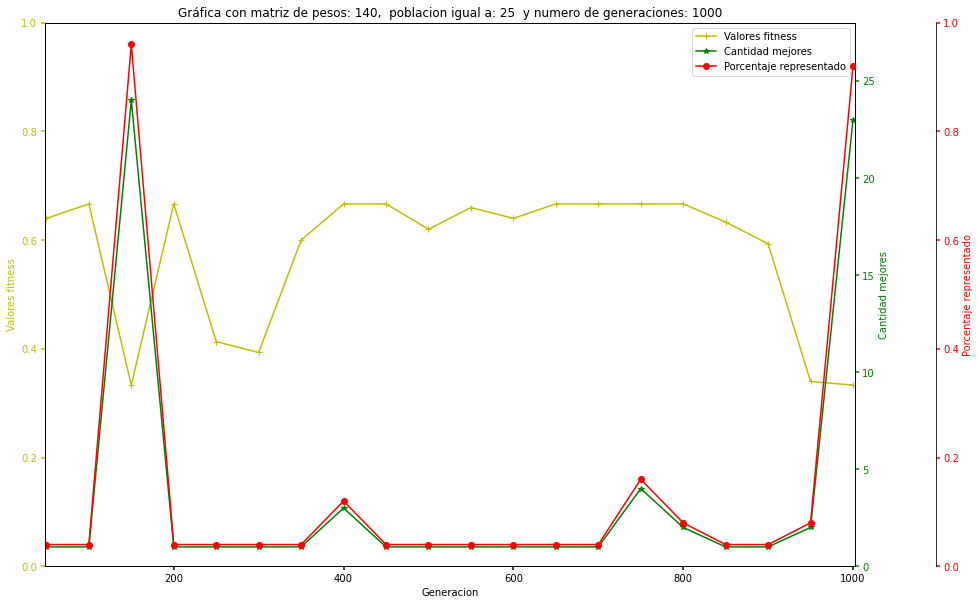

In [22]:
pintarGrafica(valoresGeneracion1, valoresFitness1, valoresNumMejores1, valoresPorcentajeRepresentado1,
              MatrizPesos, NPOB, NGEN, 'Generacion', NRES, NGEN)

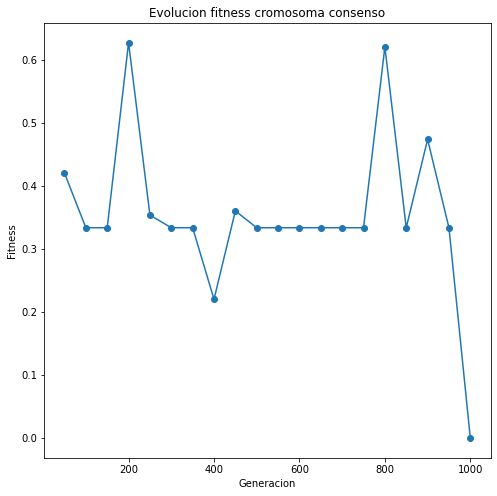

In [23]:
plt.figure(figsize = (8, 8))
plt.plot(valoresGeneracion1, fitnessConsenso1, marker = 'o')
plt.title('Evolucion fitness cromosoma consenso')
plt.xlabel('Generacion')
plt.ylabel('Fitness')
plt.show()

#### Algoritmo genetico en el que la probabilidad de mutacion aumenta hasta un 80% durante la ejecucion

In [41]:
# Se genera la poblacion inicial de individuos
listaIndividuos = generarPoblacion(NPOB)

# Se calcula el fitness de todos ellos
fitnessIndividuos = calcularFitness(X, y, listaIndividuos, cantidadPesosEntrada, pesosIniciales)

# Se calcula cuanto debe aumentar Pm en cada ejecucion para que en al final del algoritmo haya 
# aumentado un 80% (en este caso)
cantidadAumento = (Pm*80)/100
aumentoPorGeneracion = cantidadAumento/NGEN

In [42]:
print(f"------------------\nMatrizPesos: {MatrizPesos}\nNumero de individuos de la poblacion: {NPOB}" +
      f"\nNumero de generaciones: {NGEN}\nProbabilidad de mutacion: {Pm}\n------------------\n\n")

contNRES = 1
contNSAMPLE = 1

# Listas para almacenar los valores necesarios para pintar graficas
# Estos valores solamente se almacenaran cada vez que se cumpla la condicion 'contNRES%NRES == 0'
valoresFitness2 = []
valoresNumMejores2 = []
valoresPorcentajeRepresentado2 = []
valoresProbMutacion2 = []
cromosomasConsenso2 = []
fitnessConsenso2 = []

generaciones = NGEN

while generaciones != 0:    
    
    listaIndividuos, fitnessIndividuos = entrecruzamiento(listaIndividuos, fitnessIndividuos)
    
    
    if contNRES%NRES == 0:
        print(f"\n------------------\nProbabilidad de mutacion: {Pm}\n------------------\n")
        bestF, cantidadMejores, porcentaje, cConsenso, fConsenso = resumenGeneracion(contNRES, listaIndividuos, fitnessIndividuos)
        
        valoresFitness2.append(bestF)
        valoresNumMejores2.append(cantidadMejores)
        valoresPorcentajeRepresentado2.append(porcentaje)
        valoresProbMutacion2.append(Pm)
        cromosomasConsenso2.append(cConsenso)
        fitnessConsenso2.append(fConsenso)
        
        print("\n\n")

    if contNSAMPLE%NSAMPLE == 0:
        print(f"\n------------------\nProbabilidad de mutacion: {Pm}\n------------------\n")
        resumenMuestra(contNRES, listaIndividuos, fitnessIndividuos)
        print("\n\n")
        
        
    contNRES += 1
    contNSAMPLE += 1
    generaciones -= 1
    
    if Pm < 1:
        Pm += aumentoPorGeneracion
        if Pm > 1:
            Pm = 1
    
print("\n\n<<<< EL ALGORITMO HA FINALIZADO SU EJECUCION >>>>\n")
print(f"\n------------------\nProbabilidad de mutacion: {Pm}\n------------------\n")
resumenMuestra(contNRES-1, listaIndividuos, fitnessIndividuos)

------------------
MatrizPesos: 140
Numero de individuos de la poblacion: 20
Numero de generaciones: 600
Probabilidad de mutacion: 0.05787200000000005
------------------



------------------
Probabilidad de mutacion: 0.06165297066666663
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 50

El numero de cromosomas que destacan es de: 2
Estos representan el 10.0 % de la poblacion
Fitness: 0.6666666666666666

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.05591843 -0.75033774  0.21064935 -0.29630746 -0.30462805  0.53200675
   0.27302866 -0.72355682  0.24029919 -0.65595081 -0.25238834 -0.80561618
  -0.80356969  0.65934387 -0.76885689  0.54647237 -0.14686885 -0.75787664
   0.77694211  0.87783462]
 [ 0.43905277 -0.09896852 -0.43077879  0.80385904 -0.64166302 -0.96471988
   0.76898311 -0.64243473 -0.79321856  0.50916878 -0.2096418   0.80126986
  -0.14181153  0.20445439  0.47649322 -0.16332511 -0.97177159 -0.48968625
  -0.9378991


------------------
Probabilidad de mutacion: 0.07322737066666735
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 200

El numero de cromosomas que destacan es de: 19
Estos representan el 95.0 % de la poblacion
Fitness: 0.3333333333333333

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.81176157  0.18675311 -0.28082605 -0.61065649 -0.64670202 -0.40541591
   0.8086671  -0.22561661  0.03834621  0.83358539  0.26752646  0.0066292
  -0.05115605 -0.82019772  0.107004    0.75953432 -0.5371021  -0.52695307
   0.15621999  0.68399923]
 [-0.32746946  0.52469016 -0.85649046 -0.81682847  0.06473466  0.68896135
   0.78058872 -0.46783709  0.33816049  0.56258274  0.81886114 -0.86864555
   0.36102024  0.52891085  0.14621991 -0.79076984 -0.27464585 -0.48638079
   0.89826645  0.23612062]
 [-0.69696702  0.09886703  0.23818159 -0.9790866  -0.1185206  -0.58377319
  -0.73337341 -0.95506074  0.93862414 -0.58608015 -0.82578439  0.38830262
   0.273


------------------
Probabilidad de mutacion: 0.07708550400000094
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 250

El numero de cromosomas que destacan es de: 1
Estos representan el 5.0 % de la poblacion
Fitness: 0.66

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.06685154  0.20249278 -0.1126471   0.53830723 -0.71405925  0.56888328
   0.13340896  0.6157073   0.94901093 -0.35069892  0.82334459 -0.46806418
  -0.40691556 -0.0136451   0.16121638  0.68283827  0.68749144  0.61723
  -0.86375679 -0.24249821]
 [-0.16568491  0.71324546  0.72659977 -0.15564546 -0.04528794 -0.82978038
  -0.32611842 -0.85548453 -0.84673478 -0.20806028 -0.38689497  0.21038721
  -0.767871    0.52891085 -0.7371041   0.56696269  0.77559904 -0.54986514
   0.41066129 -0.41596352]
 [ 0.81275137  0.81951841  0.70605002  0.23156986  0.86556727 -0.7150127
  -0.36290308 -0.14311539 -0.1093821  -0.62120288 -0.53825005 -0.72676917
  -0.13127907 -0.75312143  


------------------
Probabilidad de mutacion: 0.08865990400000173
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 400

El numero de cromosomas que destacan es de: 1
Estos representan el 5.0 % de la poblacion
Fitness: 0.37333333333333335

Pesos del primer individuo de los mejores de la poblacion:

[[-0.13730621 -0.1388365   0.35585309 -0.58069066 -0.36860145 -0.36026504
   0.23900539 -0.66930521  0.51296459  0.78879428  0.86415648  0.77566535
   0.89663405  0.90874251  0.08227531 -0.43822233 -0.34215543 -0.71207983
   0.80663632  0.58728736]
 [-0.74358616  0.94049913 -0.30546143 -0.39854481  0.7024178   0.46892128
   0.11965994 -0.9880759  -0.16005171 -0.29229044  0.53856849 -0.27328108
   0.78174809  0.8142971   0.5280383  -0.31679857  0.62258011  0.26203256
  -0.57423558  0.41528441]
 [-0.10252005 -0.5383875   0.40443792  0.39917732  0.70021365 -0.92006135
  -0.38935524 -0.13101933 -0.08952777 -0.71887635  0.51251319 -0.71305117
   0.052


------------------
Probabilidad de mutacion: 0.09251803733333533
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 450

El numero de cromosomas que destacan es de: 2
Estos representan el 10.0 % de la poblacion
Fitness: 0.5

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.08027266  0.56779786  0.97804526 -0.07531244  0.63716129  0.25541353
   0.76985005 -0.93236562 -0.80411711  0.48653262  0.34454241  0.29284058
  -0.46952719  0.11541729  0.17424384 -0.37207475  0.32592125 -0.2433962
   0.13261184 -0.46795803]
 [ 0.39771157  0.56745744  0.72054572  0.55337372  0.6957217   0.94675915
   0.01326368 -0.65761611 -0.31124799 -0.93311554  0.01417189  0.40406743
   0.16009882 -0.76912671 -0.10193944 -0.85584145 -0.34311252  0.7813216
   0.75627616  0.35462957]
 [ 0.6606104  -0.35088997 -0.91623893  0.08223282 -0.72584222 -0.02589847
  -0.40956502 -0.88979773 -0.22901805  0.76460832 -0.39493992 -0.41135756
  -0.914256   -0.97825251


------------------
Probabilidad de mutacion: 0.10409243733333612
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 600

El numero de cromosomas que destacan es de: 2
Estos representan el 10.0 % de la poblacion
Fitness: 0.6666666666666666

Pesos del primer individuo de los mejores de la poblacion:

[[-1.32520571e-01  3.60803365e-01  1.52518557e-01 -4.75538111e-01
  -2.19342838e-01 -8.49365681e-01 -1.28596021e-01  5.90382389e-01
  -2.61597126e-01  1.22659950e-01  8.73509397e-02 -3.75975768e-01
   5.18938204e-01 -5.17442859e-01 -1.19764015e-01  5.70740186e-02
  -1.31540231e-01 -5.76436041e-01  9.19485683e-01 -8.58908784e-01]
 [ 5.00556205e-01 -2.69679715e-01  2.47801616e-01  2.82439319e-01
   6.16235233e-01  8.33263275e-01  5.05728813e-01  9.52068040e-01
   7.71952653e-01  7.93419067e-01  8.16902768e-01 -3.06238868e-01
   3.52854381e-01 -3.47843167e-01  8.16409408e-01 -9.67058679e-01
   8.31769532e-01 -8.13445976e-01 -5.33723824e-01 -5.711578


[[-1.32520571e-01  3.60803365e-01  7.11308449e-01  2.87389995e-01
   1.99653346e-01  7.50518127e-01 -9.53340331e-01 -9.01692602e-01
  -6.67813338e-01 -7.27988532e-01 -6.77562521e-01  8.92310267e-02
   5.18938204e-01  4.21395625e-01 -2.46282588e-01  5.70740186e-02
  -1.31540231e-01 -5.40711647e-01  6.05191747e-01 -8.58908784e-01]
 [ 2.08039471e-01 -9.80672431e-01 -3.66806763e-01 -2.18216490e-01
  -1.43400470e-01  6.18990996e-01 -1.44858969e-01 -5.36111202e-01
   7.71952653e-01  6.21999907e-01 -7.18965897e-01 -3.06238868e-01
   3.52854381e-01  8.23348267e-01 -8.63025307e-01  4.70163854e-01
  -7.36503521e-02 -9.21057892e-02  4.50090786e-01 -1.73137134e-01]
 [ 6.89119597e-01 -1.85055408e-02  8.74945222e-01 -6.33821670e-01
  -6.42075642e-04 -2.28375031e-01  3.90476214e-01  5.43557390e-01
   1.62809646e-01 -6.50286039e-01  3.90412042e-01 -1.76645760e-01
  -5.11039274e-01 -2.60410637e-01  2.02964421e-01 -1.12667398e-01
  -5.16732161e-01  5.90758381e-01 -8.92170749e-01  2.55813411e-02]
 [ 5.5

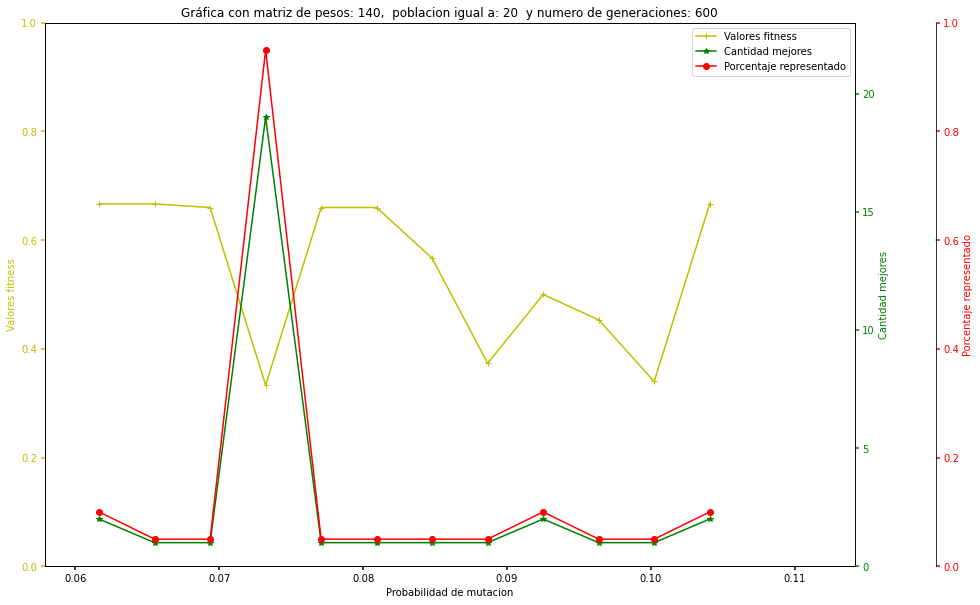

In [44]:
pintarGrafica(valoresProbMutacion2, valoresFitness2, valoresNumMejores2, 
              valoresPorcentajeRepresentado2, MatrizPesos, NPOB, NGEN, 'Probabilidad de mutacion',
              Pm-cantidadAumento, Pm + 0.01)

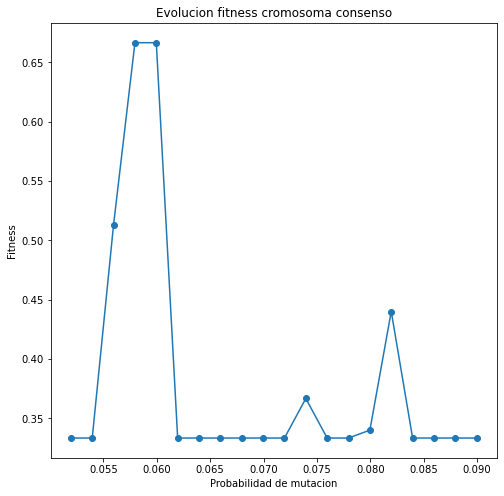

In [27]:
plt.figure(figsize = (8, 8))
plt.plot(valoresProbMutacion2, fitnessConsenso2, marker = 'o')
plt.title('Evolucion fitness cromosoma consenso')
plt.xlabel('Probabilidad de mutacion')
plt.ylabel('Fitness')
plt.show()

#### Algoritmo genetico en el que la probabilidad de mutacion comienza siendo un 1% y aumenta a medida que se ejecuta el algoritmo (pudiendo llegar al 100%)

In [28]:
# Se genera la poblacion inicial de individuos
listaIndividuos = generarPoblacion(NPOB)

# Se calcula el fitness de todos ellos
fitnessIndividuos = calcularFitness(X, y, listaIndividuos, cantidadPesosEntrada, pesosIniciales)

# Se indica que la probabilidad de mutacion aumentara un 5% (en este caso cada vez que se muestra
# un resumen de la generacion, es decir, cada NRES) y se inicializa en 5% tambien
Pm = 0.01
aumentoPorGeneracion = 0.02

In [29]:
print(f"------------------\nMatrizPesos: {MatrizPesos}\nNumero de individuos de la poblacion: {NPOB}" +
      f"\nNumero de generaciones: {NGEN}\nProbabilidad de mutacion: {Pm}\n------------------\n\n")

contNRES = 1
contNSAMPLE = 1

# Listas para almacenar los valores necesarios para pintar graficas
# Estos valores solamente se almacenaran cada vez que se cumpla la condicion 'contNRES%NRES == 0'
valoresFitness3 = []
valoresNumMejores3 = []
valoresPorcentajeRepresentado3 = []
valoresProbMutacion3 = []
cromosomasConsenso3 = []
fitnessConsenso3 = []

generaciones = NGEN

while generaciones != 0:    
    
    listaIndividuos, fitnessIndividuos = entrecruzamiento(listaIndividuos, fitnessIndividuos)
    
    
    if contNRES%NRES == 0:
        if Pm < 1:
            Pm += aumentoPorGeneracion
            if Pm > 1:
                Pm = 1
        print(f"\n------------------\nProbabilidad de mutacion: {Pm}\n------------------\n")
        bestF, cantidadMejores, porcentaje, cConsenso, fConsenso = resumenGeneracion(contNRES, listaIndividuos, fitnessIndividuos)
        
        valoresFitness3.append(bestF)
        valoresNumMejores3.append(cantidadMejores)
        valoresPorcentajeRepresentado3.append(porcentaje)
        valoresProbMutacion3.append(Pm)
        cromosomasConsenso3.append(cConsenso)
        fitnessConsenso3.append(fConsenso)
        
        print("\n\n")

    if contNSAMPLE%NSAMPLE == 0:
        print(f"\n------------------\nProbabilidad de mutacion: {Pm}\n------------------\n")
        resumenMuestra(contNRES, listaIndividuos, fitnessIndividuos)
        print("\n\n")
        
        
    contNRES += 1
    contNSAMPLE += 1
    generaciones -= 1
    
print("\n\n<<<< EL ALGORITMO HA FINALIZADO SU EJECUCION >>>>\n")
print(f"\n------------------\nProbabilidad de mutacion: {Pm}\n------------------\n")
resumenMuestra(contNRES-1, listaIndividuos, fitnessIndividuos)

------------------
MatrizPesos: 140
Numero de individuos de la poblacion: 25
Numero de generaciones: 1000
Probabilidad de mutacion: 0.01
------------------



------------------
Probabilidad de mutacion: 0.03
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 50

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.66

Pesos del primer individuo de los mejores de la poblacion:

[[ 2.08738696e-01 -5.68883056e-01 -8.35667480e-01 -6.61576053e-01
  -6.23609841e-01 -5.56267011e-01 -3.73463869e-01 -1.29764785e-01
  -6.81851574e-01 -8.26399453e-01 -5.57897246e-01 -3.14158818e-01
   6.12282510e-01  4.37722391e-01 -8.87809524e-01 -9.11066008e-04
  -7.21711072e-01  3.22393277e-01 -9.79272015e-02  7.26804197e-01]
 [ 8.93497521e-01 -6.05000710e-01 -2.26451004e-01  8.17078484e-01
  -9.48948024e-01  3.17413658e-01  5.59548304e-01 -6.57950770e-01
   6.36721176e-01  9.60217719e-01  4.84550499e-01  8.89017234e-0


------------------
Probabilidad de mutacion: 0.07
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 150

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.6666666666666666

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.2289573  -0.27832721 -0.32191804  0.57377258  0.67129523 -0.16484326
   0.31189119 -0.05614291  0.91383782 -0.40770191 -0.76177435  0.7014483
   0.58455007  0.19547415 -0.80583818  0.31409254 -0.33019195 -0.05042098
  -0.5000123   0.08590103]
 [-0.98946926  0.42332687  0.27147997  0.18893216  0.50296532  0.90254521
   0.5595483   0.97011464  0.63672118 -0.93965835 -0.58587262 -0.98941531
  -0.53968954 -0.64208172  0.85611621 -0.43208326  0.35486342 -0.62034952
  -0.5265164  -0.03014812]
 [ 0.36786288 -0.57258161 -0.60605689 -0.45355622  0.24027549  0.6932672
   0.25150673  0.52268842  0.52928541 -0.62339387  0.75123436  0.94014418
  -0.82813278  0.43905826 


------------------
Probabilidad de mutacion: 0.11000000000000001
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 250

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.6666666666666666

Pesos del primer individuo de los mejores de la poblacion:

[[-0.26004472  0.81390438  0.52995727 -0.70223989 -0.61176327 -0.58218422
  -0.8851316   0.43289934 -0.91833715 -0.89559617  0.43134134  0.64357822
  -0.38011794  0.02591198 -0.7041733  -0.88727737  0.2407312  -0.72068309
   0.93520927 -0.04145758]
 [ 0.07791671  0.53465444  0.00702771  0.18332254  0.01569858 -0.76910057
   0.36663314 -0.53327477 -0.96046094  0.51128347 -0.96749135 -0.80328597
   0.28734567 -0.73227471  0.36328787  0.82026413  0.33263248  0.64398255
  -0.62148871  0.27589041]
 [-0.96944005 -0.16600817 -0.42671969  0.09571071  0.54480058 -0.37774776
  -0.66515183 -0.14421469  0.10697939  0.43671633  0.07867323  0.70573531
  -0.6003


------------------
Probabilidad de mutacion: 0.16999999999999998
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 400

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.5933333333333334

Pesos del primer individuo de los mejores de la poblacion:

[[-0.76226737 -0.9465112  -0.63138322 -0.56697311 -0.44704377  0.37762928
  -0.75620187  0.04038952 -0.73873808  0.73085467 -0.66857349  0.453114
  -0.1697576   0.48395738 -0.38551926 -0.87647418  0.13278814 -0.1506418
  -0.23357306  0.35461153]
 [-0.15339522 -0.21508963  0.75547036  0.78822047  0.14379456 -0.76831802
  -0.73648955 -0.84781027  0.09524047 -0.29437879 -0.85505678  0.88671108
   0.21538628 -0.58076055 -0.08478209  0.93078121 -0.73471241  0.4554638
   0.43897686 -0.9640851 ]
 [-0.41717298  0.57585332 -0.52112142  0.08666281  0.93504771 -0.96270298
  -0.47734477  0.53003976 -0.21642971 -0.92827497  0.20297571  0.54024008
  -0.16825547


------------------
Probabilidad de mutacion: 0.18999999999999997
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 450

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.34

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.43652711 -0.56058056  0.68177969 -0.01466241  0.57559832  0.39810619
   0.43819389 -0.71203799 -0.42920145 -0.2581806   0.41573846  0.19198169
  -0.43626192 -0.72074109  0.17318318  0.310391    0.18675358  0.14919781
   0.74317855  0.70908167]
 [-0.69980903 -0.85563993 -0.56992302 -0.16611899  0.37841525  0.59713374
  -0.59781402  0.0399004   0.88052219  0.52567558  0.99489497 -0.25033072
   0.47856991 -0.49617234 -0.38130202  0.3827284   0.6661599  -0.84001567
   0.92166315  0.72931957]
 [ 0.99822867 -0.23744674  0.07872202  0.6343944  -0.59229719  0.09824196
  -0.70219786 -0.46905898  0.04978893 -0.56256557 -0.87631492  0.53489121
  -0.96405232  0.729155


------------------
Probabilidad de mutacion: 0.24999999999999994
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 600

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.5333333333333333

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.26010925  0.33861892 -0.74883461 -0.0156703  -0.37235764 -0.53439336
  -0.06020116 -0.95750497  0.63995468  0.53215645 -0.60886412  0.24713474
   0.7536487  -0.67399152  0.89489165 -0.13263745 -0.83313247 -0.29696602
  -0.24701795 -0.20448189]
 [ 0.27997578  0.42330713  0.90332061  0.61885718 -0.44246762 -0.16394862
  -0.26619285 -0.69458311  0.38014908 -0.09616627 -0.61580511 -0.94500024
  -0.10804313  0.47920719 -0.39363393 -0.84589199  0.77514304  0.11156291
  -0.70134585 -0.79242122]
 [ 0.50925696 -0.80338562  0.31612169 -0.99377433 -0.16989868 -0.15086165
  -0.55072237 -0.79031957  0.55340454 -0.6467908   0.08500677  0.46870445
  -0.9017


------------------
Probabilidad de mutacion: 0.26999999999999996
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 650

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.5333333333333333

Pesos del primer individuo de los mejores de la poblacion:

[[-0.19612193 -0.1477916   0.70851955  0.3129973   0.02116958 -0.42687144
   0.67285795 -0.33985218 -0.59627969 -0.27145437  0.20403005 -0.4522501
  -0.82136331 -0.67742795  0.79607094 -0.12103527  0.23174007  0.83389066
   0.6537996   0.17758766]
 [ 0.23095952 -0.01242374  0.30222294 -0.7073311  -0.42225932 -0.72037181
   0.84317384 -0.99041143 -0.60517338 -0.44731273 -0.54424192  0.32114472
   0.45482736  0.06590036  0.75929607  0.16821716 -0.31494212  0.42525025
   0.86565756 -0.52685522]
 [-0.34578791 -0.58566088 -0.92953691  0.30214999 -0.07803228  0.93739576
  -0.72153583  0.15333034  0.292824    0.84235174  0.64807766 -0.54711139
   0.30546


------------------
Probabilidad de mutacion: 0.31
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 750

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.37333333333333335

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.73085418 -0.14841457 -0.87218698  0.17463087  0.49934849  0.3842478
  -0.36086399  0.54641571 -0.92014583  0.75289284 -0.68554395 -0.19858988
  -0.30278119 -0.94798922 -0.47710202 -0.68377114 -0.39726011  0.37829603
  -0.75069123 -0.36237953]
 [ 0.23272737  0.87388954 -0.81193189  0.91288608 -0.62171293 -0.40031135
  -0.52366405  0.17382346 -0.88076682  0.3734655  -0.35043139  0.61744065
   0.23761989  0.12586345 -0.05686715  0.36363943 -0.91098106 -0.73502153
  -0.68522546  0.0764237 ]
 [-0.415138   -0.51847287  0.65613299 -0.2263885   0.35058196 -0.64847171
  -0.11180262 -0.64727005 -0.81276302 -0.41458698 -0.12935876 -0.20174526
  -0.52946569 -0.6869868


------------------
Probabilidad de mutacion: 0.35000000000000003
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 850

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.6666666666666666

Pesos del primer individuo de los mejores de la poblacion:

[[ 0.25586532  0.76600737 -0.24247883 -0.56358282  0.35044936  0.27321266
   0.75044728  0.69215234  0.38866092  0.0896533   0.24782511 -0.96195568
   0.53740179 -0.12514768  0.87028872 -0.53897298 -0.95087375  0.66060589
  -0.38677463 -0.22131111]
 [-0.62049193 -0.35395195  0.81625566  0.25053997  0.80624197  0.8588999
   0.62726249 -0.38565114  0.32158265 -0.12004794 -0.83630347 -0.62454614
   0.41714518 -0.03056129 -0.5311989  -0.96011496  0.26113123 -0.87158099
   0.94063222 -0.86318411]
 [ 0.34061705  0.31261981 -0.73645519  0.27278516 -0.98513306  0.95930784
  -0.06194997 -0.94542631  0.18468959 -0.46698915 -0.9025945  -0.62399415
   0.13579


------------------
Probabilidad de mutacion: 0.4100000000000001
------------------

	- RESUMEN DE GENERACION
--------------------------------------
Generacion: 1000

El numero de cromosomas que destacan es de: 1
Estos representan el 4.0 % de la poblacion
Fitness: 0.6666666666666666

Pesos del primer individuo de los mejores de la poblacion:

[[-0.70319517 -0.10617921  0.42387179  0.67641652 -0.56850289  0.09964428
  -0.30406896 -0.57974146 -0.51046031 -0.68701059  0.64252839 -0.7260695
   0.71456498 -0.73848226 -0.95252445 -0.89921031  0.50932045  0.30645133
  -0.83793816 -0.54908471]
 [-0.81230686 -0.49752176  0.84058066 -0.0344348  -0.84229923  0.89491714
  -0.22335223  0.62149384  0.9767832   0.87292777  0.9677639   0.40773087
   0.11147767 -0.16398647  0.52987763 -0.03366725 -0.58093112  0.76242891
   0.52281017  0.69468942]
 [-0.46151546  0.51411476 -0.16144105 -0.29465842 -0.55822467 -0.96862405
  -0.80314782 -0.42087945  0.51156849  0.08721812  0.71939294 -0.50665977
   0.77868


Fitness del cromosoma consenso: 0.3333333333333333
Pesos del cromosoma consenso: 

[[-0.67874039  0.59986268 -0.68715449 -0.63294736 -0.08187571  0.86486304
   0.07316224 -0.48457521  0.27774963 -0.15324394  0.67874447  0.4544564
   0.1213738   0.48350212  0.44906799  0.8494283   0.94061291 -0.59372135
  -0.28293024 -0.65365066]
 [-0.51934514 -0.41193837  0.27077172  0.10515481 -0.03531709 -0.84443818
   0.63908141  0.46881537  0.20286181 -0.80256903 -0.54979264 -0.95040615
  -0.54039184 -0.7249762   0.27107589 -0.02542131 -0.62212015  0.28912639
  -0.40892586  0.43366434]
 [ 0.43083842 -0.49054272  0.43688682 -0.47431677  0.69054326 -0.74352898
   0.90615439 -0.80380216 -0.35510124  0.98072261  0.80050173  0.43383214
  -0.02699002 -0.25799017 -0.58207642 -0.93711003  0.40347689 -0.23018624
  -0.77694525  0.92431941]
 [-0.62648559 -0.60327469 -0.25943565  0.92634459 -0.3803416  -0.0328086
  -0.08942994  0.23928842  0.79236369 -0.22283556  0.13127814  0.72385521
   0.94970575 -0.106225

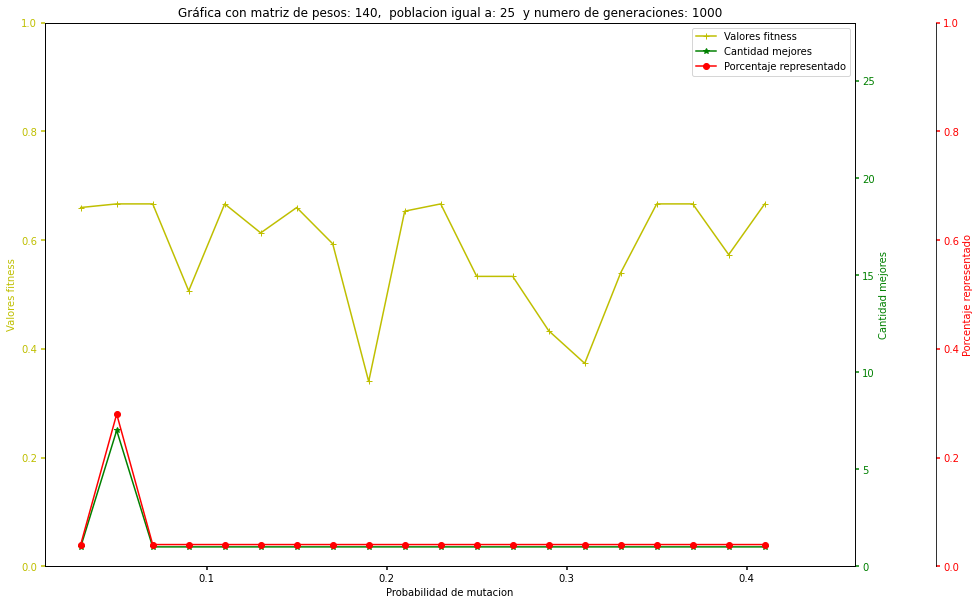

In [30]:
pintarGrafica(valoresProbMutacion3, valoresFitness3, valoresNumMejores3,
              valoresPorcentajeRepresentado3, MatrizPesos, NPOB, NGEN, 'Probabilidad de mutacion',
              0.01, Pm+0.05)

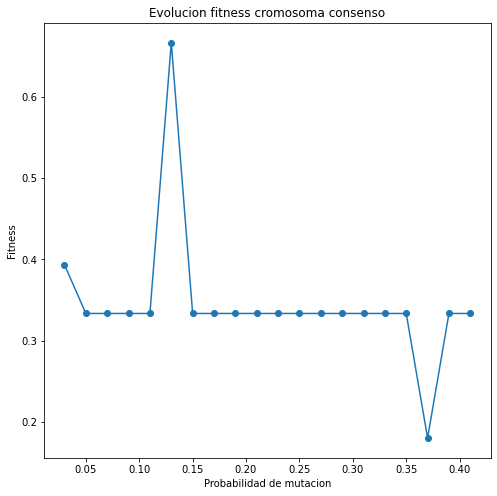

In [31]:
plt.figure(figsize = (8, 8))
plt.plot(valoresProbMutacion3, fitnessConsenso3, marker = 'o')
plt.title('Evolucion fitness cromosoma consenso')
plt.xlabel('Probabilidad de mutacion')
plt.ylabel('Fitness')
plt.show()